In [1]:
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pyidi

Specify the `.cih` file (or the new version `.cihx`) that has the same name as `.mraw` file with images:

In [2]:
filename = 'data/data_showcase.cih'

Make an instance of `VideoReader` class:

In [3]:
video = pyidi.VideoReader(filename)

Get the video dimensions:

In [4]:
print(f"N images: {video.N}")
print(f"Image height: {video.image_height}")
print(f"Image width: {video.image_width}")

N images: 75
Image height: 40
Image width: 640


To get a specific frame from the video, use `.get_frame` method:

In [5]:
video.get_frame(0)

memmap([[33, 36, 42, ..., 49, 50, 43],
        [30, 37, 40, ..., 47, 46, 46],
        [31, 39, 38, ..., 45, 47, 43],
        ...,
        [79, 79, 86, ..., 78, 71, 57],
        [83, 84, 86, ..., 80, 71, 62],
        [81, 84, 83, ..., 83, 75, 64]], shape=(40, 640), dtype=uint8)

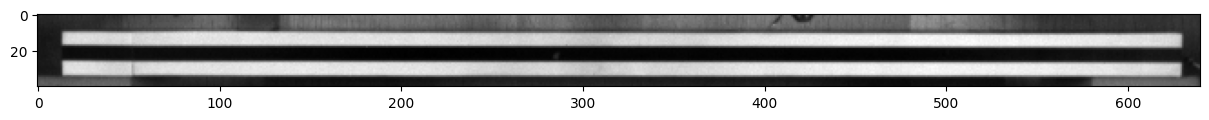

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(video.get_frame(0), 'gray')

Points where the displacements will be identified must be determined. Chosen points must have high gradient value.

In [7]:
reference_image = np.average(video.mraw[:10], axis=0)

grad0, grad1 = np.gradient(reference_image)

In [8]:
inds = np.array([[ 26,  20],
               [ 18, 180],
               [ 26, 340],
               [ 26, 500]])

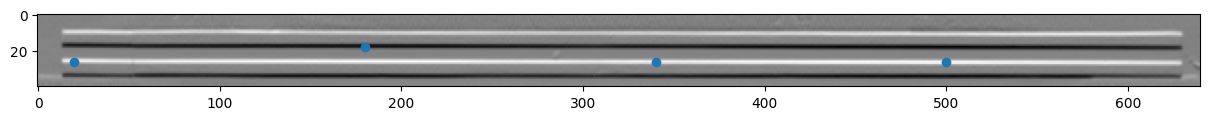

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(grad0, 'gray')
ax.scatter(inds[:, 1], inds[:, 0])

Setting the points and method to be used:

In [10]:
idi = pyidi.SimplifiedOpticalFlow(video)
idi.configure(subset_size=3, reference_range=(0, 10)) # Configuring the arguments

If the `points` argument is not given and the `method` is supplied to `set_points`, the `get_points` method is triggered. 

`kwargs` can be passed to `get_points`.

In [11]:
idi.set_points(points=inds)

The displacements are identified by calling `get_displacements`

In [12]:
displacements = idi.get_displacements()

  0%|                                                                        | 0/75 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 755.43it/s]

data\data_showcase_pyidi_analysis\analysis_001\ analysis_001


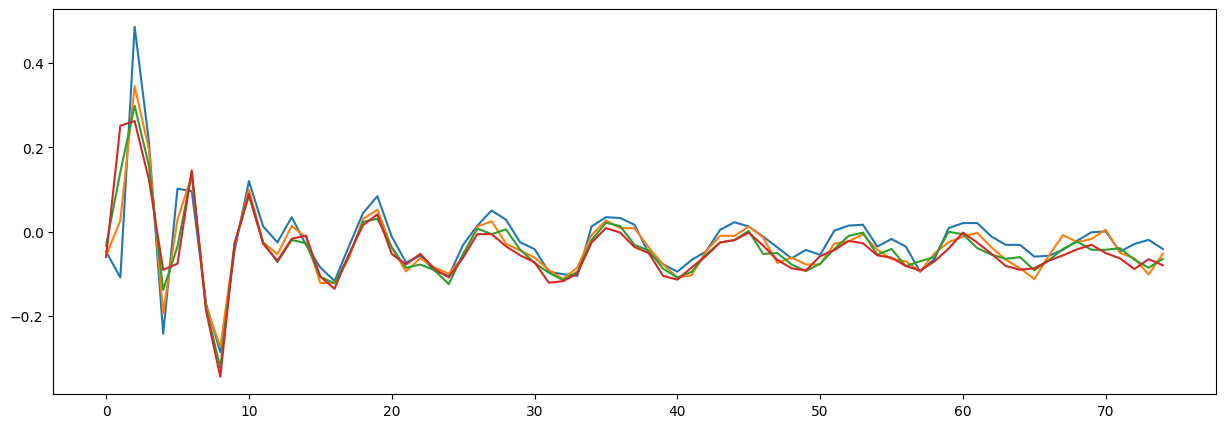

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(displacements[:, :, 0].T);

# Lucas-Kanade

Lucas-Kanade method is shown on synthetic data.

In [14]:
filename_2 = 'data/data_synthetic.cih'
video_2 = pyidi.VideoReader(filename_2)

In [15]:
print(f"N images: {video_2.N}")
print(f"Image height: {video_2.image_height}")
print(f"Image width: {video_2.image_width}")

N images: 101
Image height: 128
Image width: 256


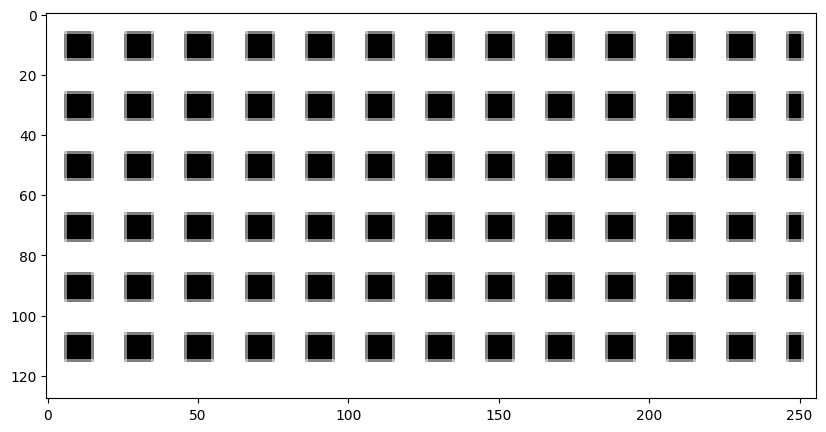

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(video_2.get_frame(0), 'gray');

In [17]:
reference_image_2 = np.average(video_2.mraw[:10], axis=0)
grad0_2, grad1_2 = np.gradient(reference_image_2)

In [18]:
inds_2 = np.array([
    [ 31,  35],
    [ 91,  35],
    [ 31, 215],
    [ 91, 215],
    [ 31, 126],
    [ 91, 126],
    [ 66,  71],
    [ 35,  71],
    [ 95,  71],
    [ 66, 191],
    [ 35, 191],
    [ 95, 191]
])

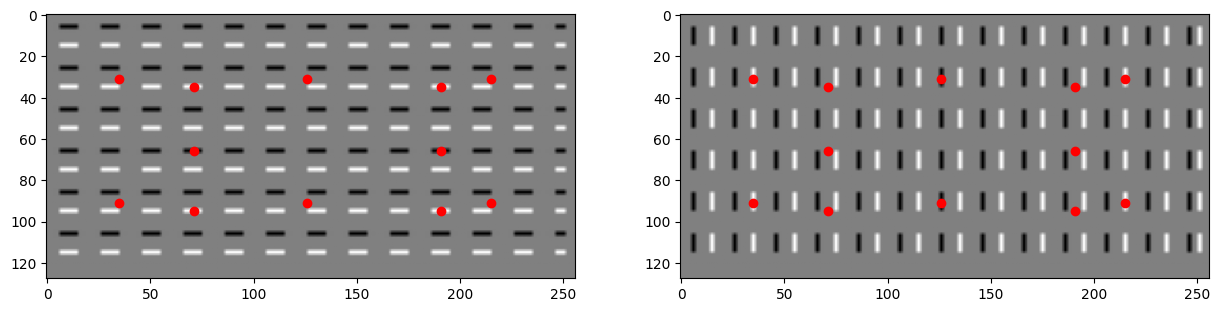

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(grad0_2, 'gray')
ax[0].scatter(inds_2[:, 1], inds_2[:, 0], c='r')
ax[1].imshow(grad1_2, 'gray')
ax[1].scatter(inds_2[:, 1], inds_2[:, 0], c='r');

In [20]:
generated_t, generated_x, generated_y = np.load('./data/data_synthetic_generated.npy')

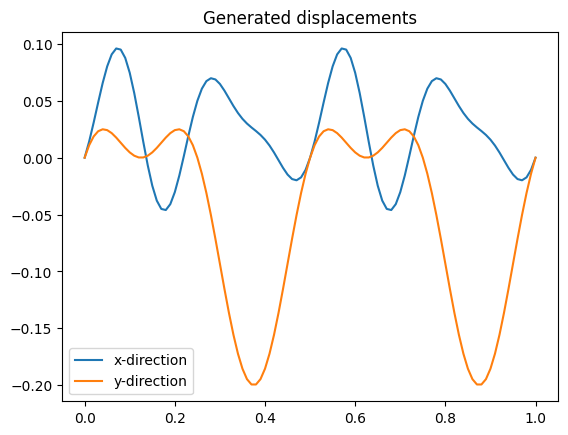

In [21]:
plt.plot(generated_t, generated_x, label='x-direction')
plt.plot(generated_t, generated_y, label='y-direction')
plt.title('Generated displacements')
plt.legend();

In [22]:
idi_lk = pyidi.LucasKanade(video_2)
idi_lk.set_points(points=inds_2)

In [23]:
idi_lk.configure(show_pbar=False)

For accurate results, make sure at least 2 "speckles" are inside the ROI.

In [24]:
disp_2 = idi_lk.get_displacements(roi_size=(17, 27), int_order=1)

c:\Users\Klemen\D_drive\git_repos\pyidi_fork\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

--- Starting new analysis ---
 
Interpolating the reference image...
...done in 0.00 s


Time to complete: 1.2 s
data\data_synthetic_pyidi_analysis\analysis_004\ analysis_004


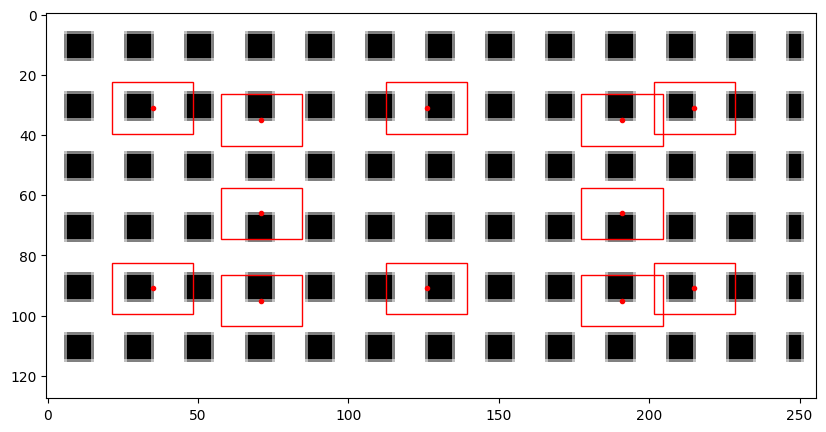

In [25]:
idi_lk.show_points()

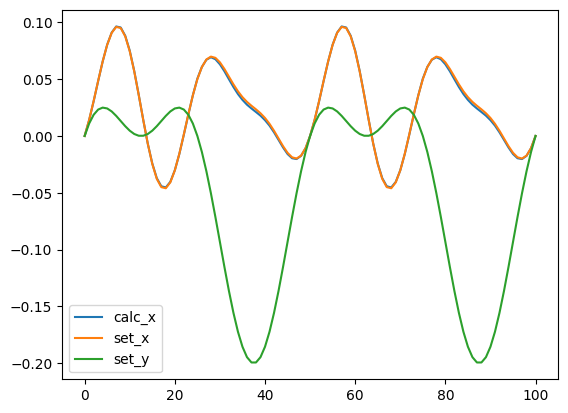

In [26]:
plt.plot(disp_2[0, :, 1] - disp_2[0, 0, 1], label='calc_x')
plt.plot(generated_x, label='set_x')
plt.plot(generated_y, label='set_y')
plt.legend()

# Multiprocessing
When using the Lucas-Kanade method, the identification can be slow, especially when large number of points is used. To reduce the computation time you can use multiprocessing:

In [27]:
idi_lk = pyidi.LucasKanade(video_2)
idi_lk.set_points(inds_2)

Other configurations can be made:

In [28]:
idi_lk.configure(int_order=1, roi_size=(25, 25))

In [29]:
disp_multi = idi_lk.get_displacements(processes=4, resume_analysis=False)

--- Starting new analysis ---
 
Computation start: 2025-05-07 11:05:43.664858


Computation duration: 00:00:4.56
data\data_synthetic_pyidi_analysis\analysis_005\ analysis_005


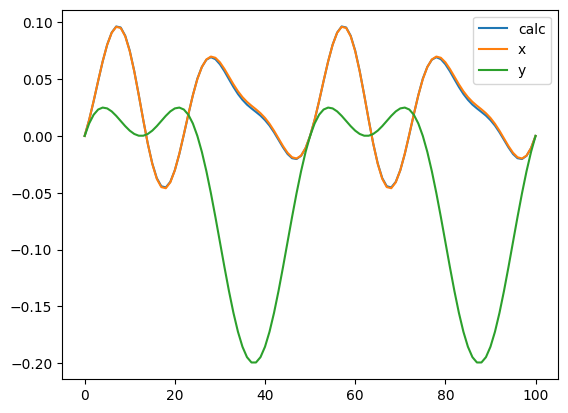

In [30]:
plt.plot(disp_multi[0, :, 1] - disp_multi[0, 0, 1], label='calc')
plt.plot(generated_x, label='x')
plt.plot(generated_y, label='y')
plt.legend()

# Analyzing other video formats

Along with the Photron MRAW, PyIDI also supports loading images in the `numpy.ndarray` (or `numpy.memmap`) format.

You can use this feature to analyze any images that can be loaded into Numpy.

PyIDI currently only supports grayscale images, structured into 3D Numpy array objects shaped `(n_images, height, width)`.

To load a video from a Numpy array object, simply pass the array into `pyidi.pyIDI` instead of the `.cih` file path:


In [31]:
# Prepare the numpy array
import pyMRAW
memmap_video, _ = pyMRAW.load_video(filename_2)
array_video = np.array(memmap_video)

type(array_video), array_video.shape

(numpy.ndarray, (101, 128, 256))

The resulting `pyIDI` object can now be used normally:

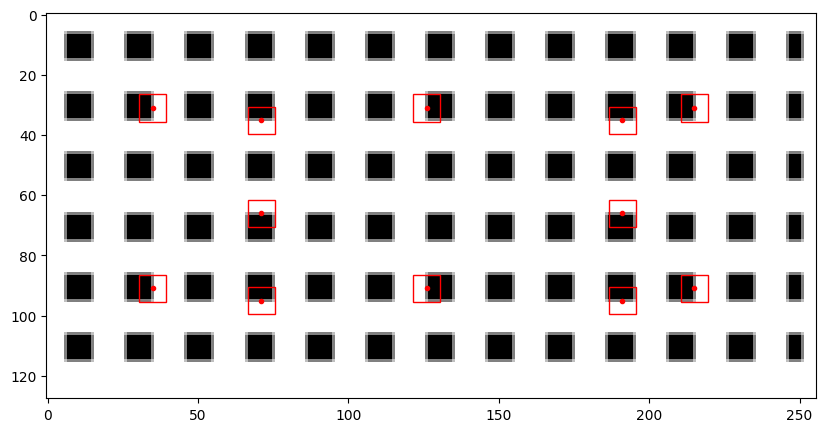

In [32]:
video_3 = pyidi.VideoReader(array_video, root='./temp')

idi_lk = pyidi.LucasKanade(video_3)
idi_lk.set_points(inds_2)
idi_lk.show_points()

In [33]:
d3 = idi_lk.get_displacements()

--- Starting new analysis ---
 
Interpolating the reference image...
...done in 0.00 s


Time to complete: 1.7 s


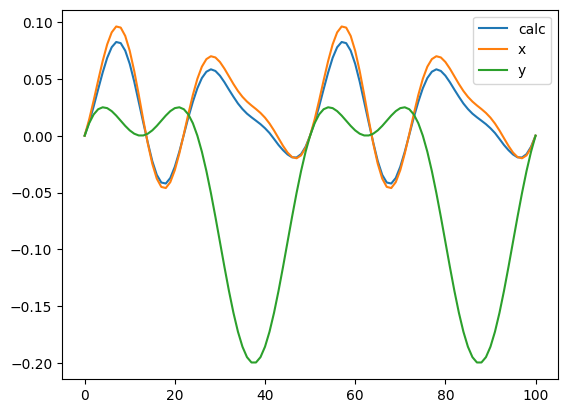

In [34]:
plt.plot(d3[2, :, 1] - d3[2, 0, 1], label='calc')
plt.plot(generated_x, label='x')
plt.plot(generated_y, label='y')
plt.legend()